# Look at where the animal are during and around non-singing

In [85]:
import os
import yaml
import numpy as np
import scipy.io
import scipy.signal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Constants

In [141]:
SAVE_FIG = False
SAVE_FIG_FORMAT = "pdf"
SAVE_FIG_DIR = "/home/csk/Documents/Research/Modeling singing mouse behavior/plots/concat"
NOTES_FILEPATH = "/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/02_20230919_um008_uf003_mf/02_social/process_audio/all_notes/concat_all_notes_corrected_features_temporal.csv"
SONGS_FILEPATH = "/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/02_20230919_um008_uf003_mf/02_social/process_audio/all_song_detections/concat_song_detections.csv"
COMMON_WORLD_COORDS_FILEPATH = "/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/02_20230919_um008_uf003_mf/02_social/process_video/2023-09-20-100934_cam0_00000_to_00004.concat_common_coords.mat"
L_COORDS_FILEPATH = "/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/cam_params/cage_coords_21415940_corrected.yml"
R_COORDS_FILEPATH = "/mnt/labNAS/Chris/mousesong/usv_calls/08_solosocial/cam_params/cage_coords_21428187_corrected.yml"
COLOR_LEFT_MOUSE = "tab:blue"
COLOR_RIGHT_MOUSE = "tab:orange"
t_before = 10
t_after = 0

## Load tracking file and skeleton

In [87]:
# load world coords
locations_world = scipy.io.loadmat(COMMON_WORLD_COORDS_FILEPATH, squeeze_me=True)
l_locations_world = locations_world["l_locations_world"]
r_locations_world = locations_world["r_locations_world"]
fps = 50

In [88]:
with open(L_COORDS_FILEPATH, "r") as f:
    l_coords = yaml.safe_load(f)
l_coords_world = l_coords["world_cage"]
with open(R_COORDS_FILEPATH, "r") as f:
    r_coords = yaml.safe_load(f)
r_coords_world = r_coords["world_cage"]

In [89]:
skeleton = np.array([[2, 0], [2, 1], [0, 1], [2, 3], [3, 4], [4, 5]])

## load songs and non-songs

In [96]:
non_songs_df = pd.read_csv(NOTES_FILEPATH, usecols=["start", "end", "code", "type_amplitude"])
songs_df = pd.read_csv(SONGS_FILEPATH, usecols=["start", "end", "code"])
filtered_non_songs_df = non_songs_df[(non_songs_df["code"] != 6) & (non_songs_df["type_amplitude"] == "non-song")]
non_songs = list(filtered_non_songs_df.itertuples(index=False, name=None))
songs = list(songs_df.itertuples(index=False, name=None))

## plot male (left) non-song rate

[1858.4818141822984, 2379.196576410831, 2486.926944766628, 2569.6273247210333, 2689.46043274807, 4023.955749310083, 4108.73613566372, 4223.630060392753, 4262.860712714474, 4794.008494980602, 4916.725352957645, 5236.583226012878, 5414.016877974643, 7221.962164540255, 7309.52288925329, 10312.592472903252, 10452.419629644442, 10522.926144862617, 16292.316122065353]


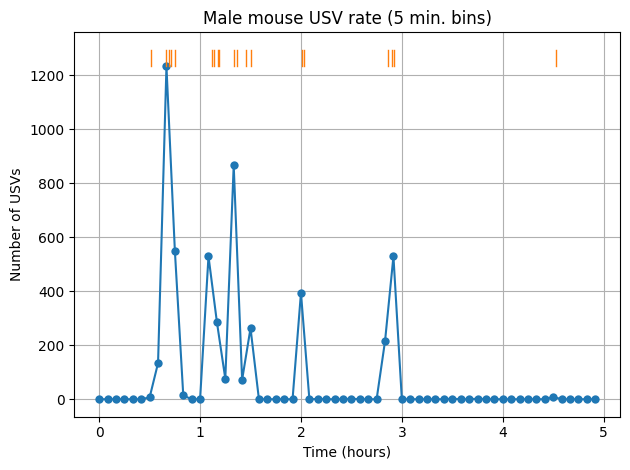

In [150]:
male_non_song_start_times = [usv[0] for usv in non_songs if usv[2] == 0]
male_song_start_times = [song[0] for song in songs if song[2] == 0]
print(male_song_start_times)
session_duration = l_locations_world.shape[0] / fps
minutes = 5
bin_size = minutes * 60
bins = np.arange(0, session_duration + bin_size, bin_size)
usv_counts, _ = np.histogram(male_non_song_start_times, bins=bins)
time_in_hours = bins[:-1] / 3600
plt.plot(time_in_hours, usv_counts, mew=0, marker="o", linestyle="-")
male_song_start_times_min = [t / 3600 for t in male_song_start_times]
# Add small black ticks on top of the bars for male song start times
tick_height = max(usv_counts) * 0.05  # Set the height of the ticks (5% of the max bar height)
for song_time in male_song_start_times_min:
    plt.plot([song_time, song_time], [max(usv_counts), max(usv_counts) + tick_height], mew=0, color='tab:orange', lw=1)
plt.xlabel("Time (hours)")
plt.ylabel("Number of USVs")
plt.title(f"Male mouse USV rate ({minutes} min. bins)")
plt.grid(True)
plt.tight_layout()
if SAVE_FIG:
    filename = f"5h__rate_non_song.{SAVE_FIG_FORMAT}"
    file = os.path.join(SAVE_FIG_DIR, filename)
    plt.savefig(file, format=SAVE_FIG_FORMAT)
plt.show()

## plot non-song position

In [92]:
spineM_idx = 4
l_spineM_world = l_locations_world[:, spineM_idx, :]
r_spineM_world = r_locations_world[:, spineM_idx, :]

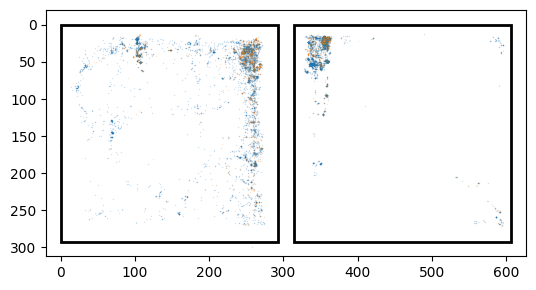

In [93]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.add_patch(
    patches.Rectangle(
        (l_coords_world["x"], l_coords_world["y"]),
        l_coords_world["w"],
        l_coords_world["h"],
        linewidth=2,
        edgecolor="k",
        facecolor="none",
    )
)
ax.add_patch(
    patches.Rectangle(
        (r_coords_world["x"], r_coords_world["y"]),
        r_coords_world["w"],
        r_coords_world["h"],
        linewidth=2,
        edgecolor="k",
        facecolor="none",
    )
)
ax.invert_yaxis()
ax.set_xlim([-20, 627])
ax.set_ylim([312, -20])
ax.set_aspect("equal", adjustable="box")
for i_non_song, non_song in enumerate(non_songs):
    t_non_song_start = non_song[0]
    t_non_song_stop = non_song[1]
    song_origin = non_song[2]
    s_non_song_start = int((t_non_song_start - t_before) * fps)
    s_non_song_stop = int((t_non_song_stop + t_after) * fps)
    if s_non_song_start < 0 or s_non_song_stop > l_spineM_world.shape[0]:
        print(f"Vocalization {i_non_song} does not have enough margin")
        continue
    if song_origin == 0:
        color = COLOR_LEFT_MOUSE
    else:
        color = COLOR_RIGHT_MOUSE
    non_song_start_loc_left = l_spineM_world[int(t_non_song_start * fps), :]
    non_song_start_loc_right = r_spineM_world[int(t_non_song_start * fps), :]
    ax.scatter(non_song_start_loc_left[0], non_song_start_loc_left[1], linewidths=0, color=color, s=1, zorder=2, alpha=0.2)
    ax.scatter(non_song_start_loc_right[0], non_song_start_loc_right[1], linewidths=0, color=color, s=1, zorder=2, alpha=0.2)
plt.tight_layout()
if SAVE_FIG:
    filename = f"5h__position_non_song.{SAVE_FIG_FORMAT}"
    file = os.path.join(SAVE_FIG_DIR, filename)
    plt.savefig(file, format=SAVE_FIG_FORMAT)
plt.show()